In [11]:
import pandas as pd
import numpy as np
from preprocess import TextPreprocessor
import matplotlib.pyplot as plt
import seaborn as sns

#### Đọc file dữ liệu đã thu thập


In [12]:
data = pd.read_csv(r"vnexpress.csv")
data.head()

,Content,Label
0,Thông tin được báo cáo chiều 12/5 trong buổi k...,Thời sự
1,"Sáng 12/5, trong Ngày hội khởi nghiệp quốc gia...",Thời sự
2,Ý kiến trên được nêu ra trong Hội thảo Chính s...,Thời sự
3,Nội dung cải cách tiền lương được nêu trong Ng...,Thời sự
4,"Tại kỳ họp 41 diễn ra ngày 7-8/5, Ủy ban Kiểm ...",Thời sự


#### In ra các nhãn của mẫu dữ liệu

In [13]:
data['Label'].unique()

array(['Thời sự', nan, 'Thế giới', 'Kinh doanh', 'Khoa học', 'Giải trí',
       'Thể thao', 'Pháp luật', 'Giáo dục', 'Sức khỏe', 'Du lịch'],
      dtype=object)

In [14]:
missing_data = data[data.isnull().any(axis=1)]
print(missing_data)

                                               Content Label
192  Bài viết của Giáo sư, Tiến sĩ, Tổng bí thư Ngu...   NaN
193                                                NaN   NaN
194                                                NaN   NaN


#### Loại bỏ các dòng có dữ liệu thiếu

In [15]:
data = data.dropna()

#### Gọi Class TextPreprocessor để thực hiện tiền xử lý dữ liệu

In [16]:
preprocessor = TextPreprocessor(r"vietnamese-stopwords.txt")
data = preprocessor.preprocess_data(data)

## TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### Sử dụng Label Encoder để mã hóa dữ liệu

In [18]:
X = data['Content']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Label'])

#### Chia tập train test theo tỷ lệ 80:20

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [20]:
#Khời tạo đối tượng TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word')
#Huấn luyện mô hình
tfidf_vect.fit(X)
#Chuyển đổi tập huấn luyện X_train thành các vector TF-IDF
X_train_tfidf =  tfidf_vect.transform(X_train)
#Chuyển đổi tập huấn luyện X_test thành các vector TF-IDF
X_test_tfidf =  tfidf_vect.transform(X_test)

In [21]:
X_test_tfidf.shape

(1810, 70004)

### Mô hình học máy SVM

In [22]:
from sklearn import svm
SVM = svm.SVC(kernel="sigmoid", C=2.25)
SVM.fit(X_train_tfidf, y_train)

SVC(C=2.25, kernel='sigmoid')

In [23]:
y_pred = SVM.predict(X_test_tfidf)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

#recall
recall = recall_score(y_test, y_pred, average='macro')  
print("Recall:", recall)
#F1
f1 = f1_score(y_test, y_pred, average='macro')  
print("F1-score:", f1)


Accuracy: 0.9475138121546961
Precision: 0.9511928354457021
Recall: 0.9420987138042543
F1-score: 0.9460488612338379


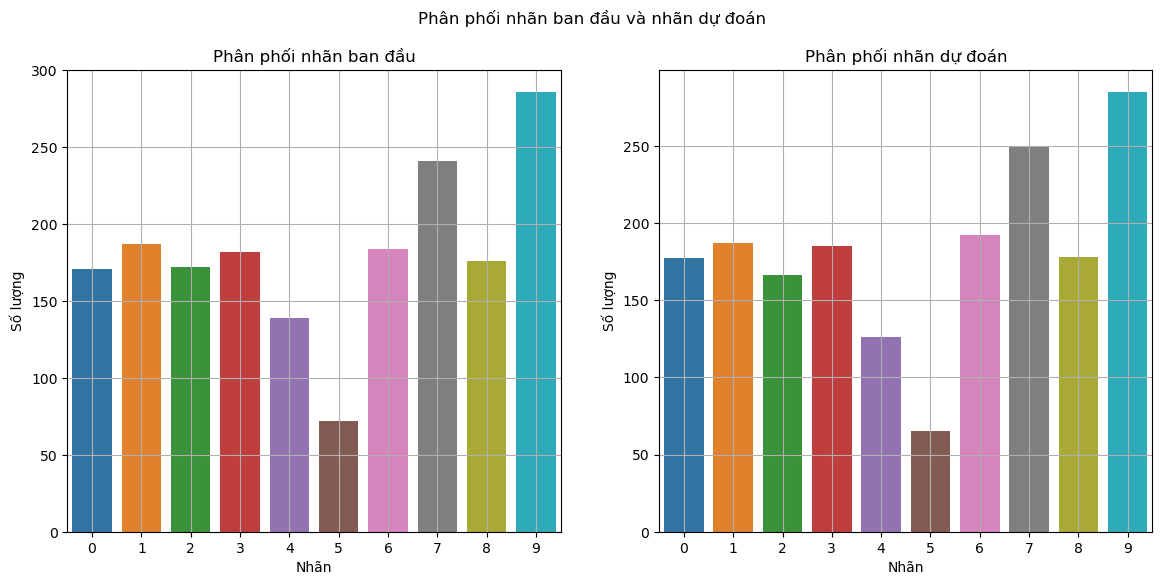

In [25]:
def plot_label_distribution(true_labels, predicted_labels, title):
    labels = sorted(set(true_labels) | set(predicted_labels))
    true_counts = [list(true_labels).count(label) for label in labels]
    pred_counts = [list(predicted_labels).count(label) for label in labels]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(x=labels, y=true_counts, ax=ax[0])
    ax[0].set_title('Phân phối nhãn ban đầu')
    ax[0].set_xlabel('Nhãn')
    ax[0].set_ylabel('Số lượng')
    ax[0].grid(True)  # Thêm dòng kẻ vào biểu đồ
    
    sns.barplot(x=labels, y=pred_counts, ax=ax[1])
    ax[1].set_title('Phân phối nhãn dự đoán')
    ax[1].set_xlabel('Nhãn')
    ax[1].set_ylabel('Số lượng')
    ax[1].grid(True)  # Thêm dòng kẻ vào biểu đồ

    fig.suptitle(title)
    plt.show()

# Vẽ biểu đồ phân phối nhãn
plot_label_distribution(y_test, y_pred, 'Phân phối nhãn ban đầu và nhãn dự đoán')

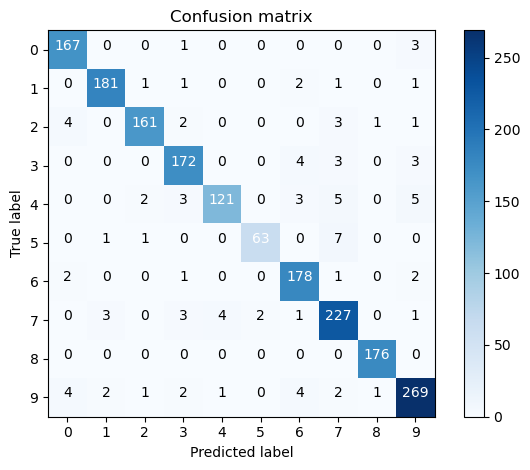

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
# Tính toán confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Hiển thị confusion matrix dưới dạng biểu đồ
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Đặt tên cho các trục
tick_marks = np.arange(10)  # Số lớp (ở đây là 10)
plt.xticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])
plt.yticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])

# Định dạng các số trên các ô
thresh = cm.max() / 10.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [27]:
import joblib

joblib.dump(SVM, 'SVM_best_model.pkl')
joblib.dump(tfidf_vect, 'tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

## Mô hình học máy Perceptron

In [28]:
# Khai báo thư viện mô hình Perceptron
from sklearn.linear_model import Perceptron
PST = Perceptron(max_iter=10000)
PST.fit(X_train_tfidf, y_train)
y_pred = PST.predict(X_test_tfidf)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

#recall
recall = recall_score(y_test, y_pred, average='macro')  
print("Recall:", recall)
#F1
f1 = f1_score(y_test, y_pred, average='macro')  
print("F1-score:", f1)

Accuracy: 0.9419889502762431
Precision: 0.9406382117919618
Recall: 0.9417635297156476
F1-score: 0.9409163713867837


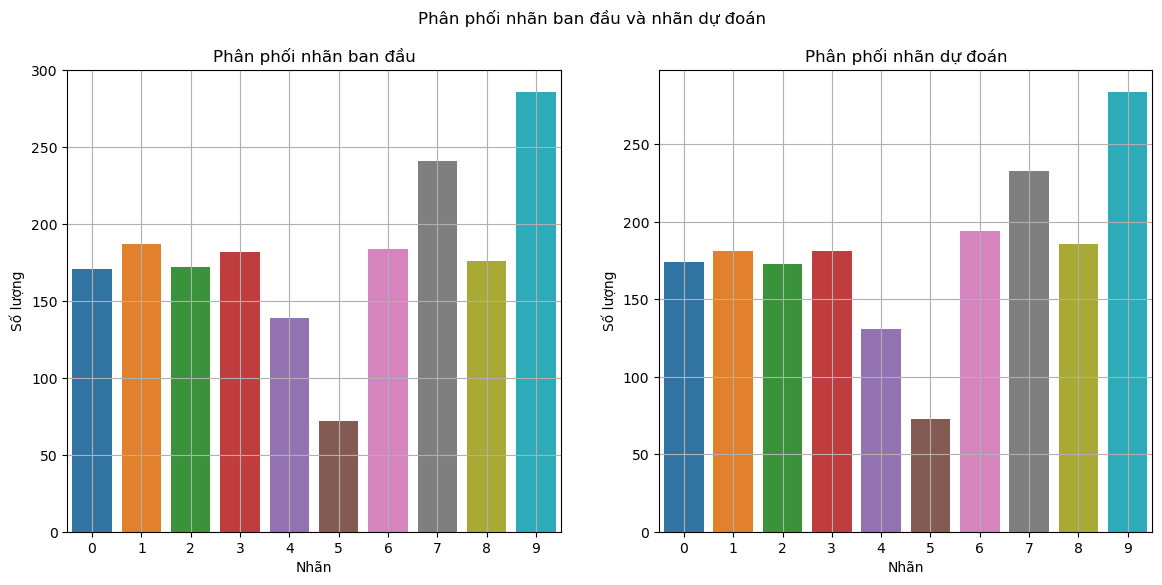

In [30]:
def plot_label_distribution(true_labels, predicted_labels, title):
    labels = sorted(set(true_labels) | set(predicted_labels))
    true_counts = [list(true_labels).count(label) for label in labels]
    pred_counts = [list(predicted_labels).count(label) for label in labels]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(x=labels, y=true_counts, ax=ax[0])
    ax[0].set_title('Phân phối nhãn ban đầu')
    ax[0].set_xlabel('Nhãn')
    ax[0].set_ylabel('Số lượng')
    ax[0].grid(True)  # Thêm dòng kẻ vào biểu đồ
    
    sns.barplot(x=labels, y=pred_counts, ax=ax[1])
    ax[1].set_title('Phân phối nhãn dự đoán')
    ax[1].set_xlabel('Nhãn')
    ax[1].set_ylabel('Số lượng')
    ax[1].grid(True)  # Thêm dòng kẻ vào biểu đồ

    fig.suptitle(title)
    plt.show()

# Vẽ biểu đồ phân phối nhãn
plot_label_distribution(y_test, y_pred, 'Phân phối nhãn ban đầu và nhãn dự đoán')

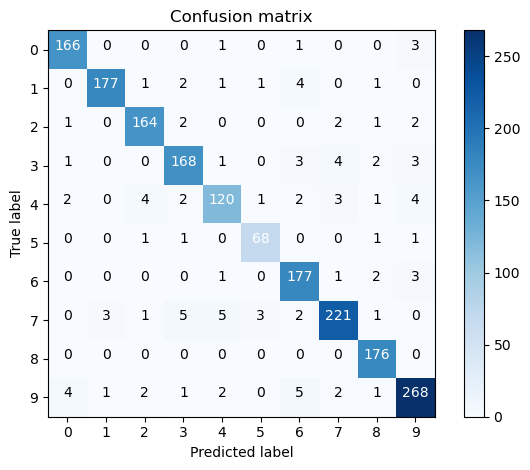

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
# Tính toán confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Hiển thị confusion matrix dưới dạng biểu đồ
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Đặt tên cho các trục
tick_marks = np.arange(10)  # Số lớp (ở đây là 10)
plt.xticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])
plt.yticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])

# Định dạng các số trên các ô
thresh = cm.max() / 10.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Mô hình học máy LogisticRegression

In [32]:
from sklearn.linear_model import LogisticRegression
# Huấn luyện mô hình với tập dữ liệu trên
LGT = LogisticRegression()
LGT.fit(X_train_tfidf, y_train)
y_pred = LGT.predict(X_test_tfidf)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

#recall
recall = recall_score(y_test, y_pred, average='macro')  
print("Recall:", recall)
#F1
f1 = f1_score(y_test, y_pred, average='macro')  
print("F1-score:", f1)

Accuracy: 0.930939226519337
Precision: 0.9349837188186877
Recall: 0.9199781390886119
F1-score: 0.9261544753678438


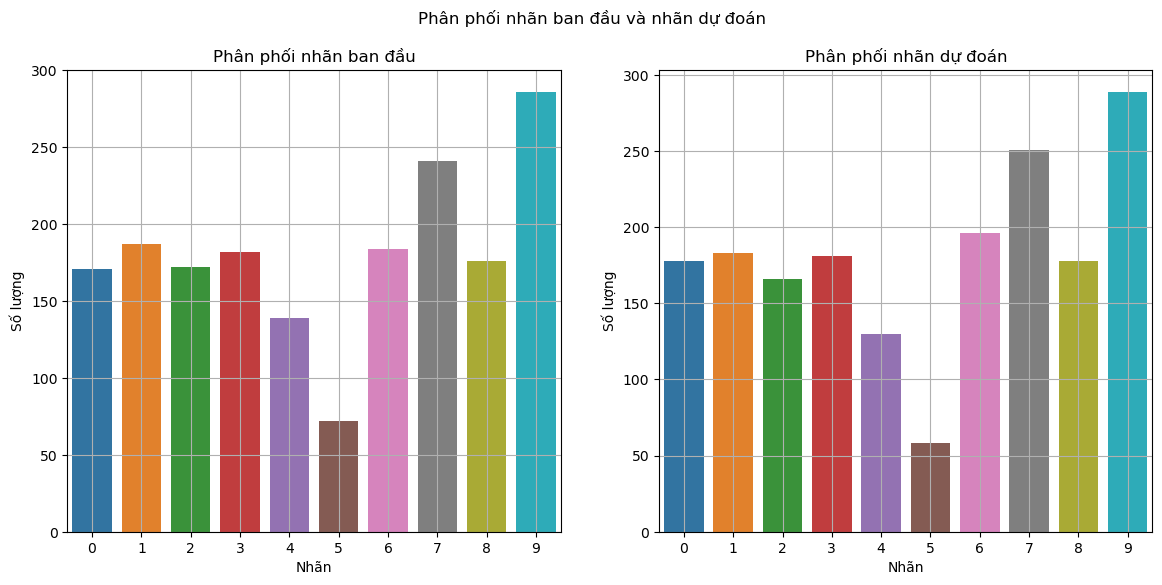

In [34]:
def plot_label_distribution(true_labels, predicted_labels, title):
    labels = sorted(set(true_labels) | set(predicted_labels))
    true_counts = [list(true_labels).count(label) for label in labels]
    pred_counts = [list(predicted_labels).count(label) for label in labels]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(x=labels, y=true_counts, ax=ax[0])
    ax[0].set_title('Phân phối nhãn ban đầu')
    ax[0].set_xlabel('Nhãn')
    ax[0].set_ylabel('Số lượng')
    ax[0].grid(True)  # Thêm dòng kẻ vào biểu đồ
    
    sns.barplot(x=labels, y=pred_counts, ax=ax[1])
    ax[1].set_title('Phân phối nhãn dự đoán')
    ax[1].set_xlabel('Nhãn')
    ax[1].set_ylabel('Số lượng')
    ax[1].grid(True)  # Thêm dòng kẻ vào biểu đồ

    fig.suptitle(title)
    plt.show()

# Vẽ biểu đồ phân phối nhãn
plot_label_distribution(y_test, y_pred, 'Phân phối nhãn ban đầu và nhãn dự đoán')

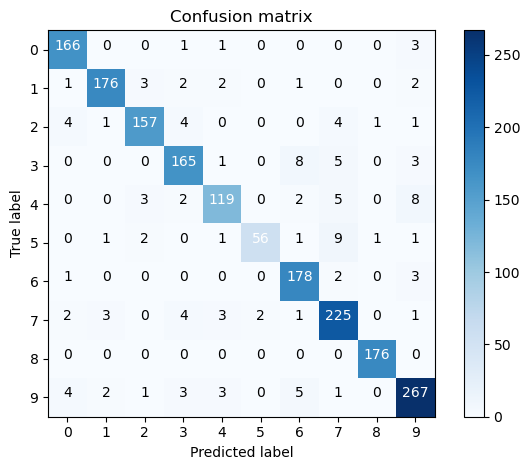

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
# Tính toán confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Hiển thị confusion matrix dưới dạng biểu đồ
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Đặt tên cho các trục
tick_marks = np.arange(10)  # Số lớp (ở đây là 10)
plt.xticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])
plt.yticks(tick_marks, ['0', '1','2','3','4','5','6','7','8','9'])

# Định dạng các số trên các ô
thresh = cm.max() / 10.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Chạy thử mô hình

#### SVM

In [36]:
sample_text1 = """Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế) cho biết, đó là tác dụng phụ đã được cảnh báo khi Việt Nam khi tổ chức tiêm vắc xin Covid-19 của AstraZeneca.
Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, sáng nay 3.5, PGS - TS Lương Ngọc Khuê, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế), cho biết đây là tác dụng phụ đã được cảnh báo khi chúng ta tổ chức tiêm vắc xin Covid-19 của AstraZeneca. Các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra
"Ngay từ đầu, chúng ta đã rất thận trọng trong tiêm chủng, mọi người đều phải khám sàng lọc rất kỹ trước khi tiêm chủng. Quy trình tiêm chủng được xây dựng chặt chẽ, người dân được kiểm tra trước tiêm, giám sát sức khỏe chặt chẽ sau tiêm", Cục trưởng Cục Quản lý khám chữa bệnh nói. Nhắc lại quy trình tiêm vắc xin Covid-19 từng được áp dụng, PGS Khuê chia sẻ, khi tiêm vắc xin Covid-19, mọi người dân trước tiêm chủng đều được kiểm tra huyết áp, theo dõi sau tiêm chủng, đặc biệt với nhóm đối tượng nguy cơ cao việc chỉ định tiêm, theo dõi sau tiêm càng thận trọng hơn. Sau này, trong quá trình theo dõi cho thấy nguy cơ tai biến ít nên quy trình tiêm được điều chỉnh, có những bệnh nhân huyết áp cao vẫn được tiêm chủng. Theo PGS Khuê, người từng tiêm vắc xin Covid-19 của hãng dược AstraZeneca cách đây 2 - 3 năm không nên hoang mang, lo lắng, bởi vắc xin chỉ có tác dụng trong vòng 1 năm.
Theo Bộ Y tế, tại Việt Nam, trong thời gian xảy ra dịch Covid-19, cả trăm triệu mũi tiêm vắc xin Covid-19 đã được tiêm cho người dân, bao gồm vắc xin của AstraZeneca, Pfizer, Moderna…, góp phần đẩy lùi dịch Covid-19. Việt Nam được đánh giá cao về tốc độ bao phủ vắc xin này. Trước đó, hồi năm 2021, thông tin quốc tế cho biết, các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra.
 Theo đó, đã phát hiện vỏ của vắc xin - được tạo bởi một loại virus gây cảm lạnh đã được làm cho suy yếu - đôi khi hoạt động giống như một nam châm hút các tiểu cầu trong máu.
Cơ thể sau đó lầm tưởng những tiểu cầu này là virus đe dọa và tạo ra kháng thể để chống lại chúng. Sự kết hợp giữa các tiểu cầu và các kháng thể kết tụ lại với nhau dẫn đến sự hình thành các cục máu đông nguy hiểm.
Nhưng họ nhấn mạnh rằng điều này là cực kỳ hiếm, chỉ có 426 trường hợp trong số khoảng 50 triệu liều vắc xin đã tiêm ở Anh, với tỷ lệ chưa đến 1/100.000."""

sample_text1 = preprocessor.preprocess_text(sample_text1)
sample_text1 =  tfidf_vect.transform([sample_text1])
y_pred1 = SVM.predict(sample_text1)
y_pred1 = label_encoder.inverse_transform(y_pred1)
y_pred1

array(['Sức khỏe'], dtype=object)

In [37]:
sample_text2 = """Ngày 6.5, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về việc thực hiện công tác phân luồng sau tốt nghiệp THCS và giao chỉ tiêu tuyển sinh lớp 10 năm học 2024-2025. Số chỉ tiêu tuyển sinh lớp 10 tăng, giảm ra sao?
Theo đó, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về công tác chuẩn bị cho kế hoạch tuyển sinh lớp 10 năm học 2024-2025. Cụ thể, tính đến tháng 1.2024, TP.HCM có 115.759 học sinh đang học lớp 9. Số học sinh dự kiến tốt nghiệp lớp 9 năm học 2023-2024 là 114.601 học sinh (tỷ lệ 99%). 
Dự kiến có khoảng 102.349 học sinh lớp 9 đăng ký tham dự kỳ thi tuyển sinh lớp 10 công lập. Và có khoảng 13.410 học sinh không tham dự kỳ thi tuyển sinh để lựa chọn phương án là du học hoặc chuyển sang học tiếp chương trình phân luồng sau tốt nghiệp THCS.  Cũng theo thống kê của Sở GD-ĐT, TP.HCM có khoảng 15.000 học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 công lập. Theo đó, gia đình và học sinh đã chủ động lựa chọn các định hướng như đi du học hoặc chuyển sang học nghề tại các trường trung cấp, CĐ, chương trình giáo dục thường xuyên (GDTX) cấp THPT trong các trung tâm giáo dục nghề nghiệp-GDTX trên địa bàn thành phố.
Số liệu cụ thể học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 của 3 năm gần nhất: Để chuẩn bị cho kỳ tuyển sinh lớp 10 năm học 2024-2025, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho 113 trường THPT công lập với tổng số 71.020 chỉ tiêu (giảm 5.324 chỉ tiêu so với năm học 2023-2024). Chỉ tiêu các trường THPT giảm chủ yếu tại TP.Thủ Đức và các quận trung tâm.
Bên cạnh đó, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho các trung tâm GDTX với chương trình GDTX cấp THPT là 12.036 học sinh.
Như vậy, theo thống kê của Sở GD-ĐT, tổng số chỉ tiêu học sinh học hoàn thành THCS có thể lựa chọn học tiếp theo chương trình THPT tại các cơ sở giáo dục công lập (trường THPT, trung tâm GDTX) là 83.856 chỉ tiêu, chiếm tỷ lệ 72% tổng số học sinh lớp 9 và chiếm 73% so với số học sinh lớp 9 dự kiến tốt nghiệp THCS năm học 2023-2024. Tuy nhiên, do số học sinh lớp 12 ra trường thấp hơn số học sinh lớp 10 nhập học hằng năm nên điều này gây áp lực lớn công tác tổ chức, sắp xếp trường lớp của hiệu trưởng các trường công lập.
Ngoài ra, TP.HCM có 8 trường CĐ, trung cấp trực thuộc Sở GD-ĐT (chưa tính hệ thống trường trung cấp thuộc Sở LĐ-TB-XH và các sở khác quản lý) có tổng số chỉ tiêu tuyển sinh lớp 10 là 10.135 học sinh. Và khoảng 80 trường THPT ngoài công tuyển 28.908 học sinh lớp 10."""

sample_text2 = preprocessor.preprocess_text(sample_text2)
sample_text2 =  tfidf_vect.transform([sample_text2])
y_pred2 = SVM.predict(sample_text2)
y_pred2 = label_encoder.inverse_transform(y_pred2)
y_pred2

array(['Giáo dục'], dtype=object)

In [38]:
sample_text3 = """Lần đầu trong lịch sử, Messi đến Canada, và anh được người Montreal chào đón. Khi xe bus chở Inter Miami tới khách sạn tại Montreal tối 11/5, hàng trăm người Canada quây quanh
chiếc xe, giơ điện thoại lên ghi hình Messi và đồng đội. Một ngày sau, họ không phải thất vọng khi Messi chơi trọn trận đấu, dù đứt mạch bảy trận ghi bàn ở MLS. MLS là giải bóng đá nhà nghề Bắc Mỹ,
với 26 đội Mỹ và ba CLB Canada, trong đó có Montreal. Khán đài sân Saputo gần như không còn chỗ trống, với gần 20.000 người tới xem. Có khán giả mặc trang phục hồng của Inter Miami, đội thêm một
chiếc mũ to hình đầu dê, ám chỉ Messi là cầu thủ vĩ đại nhất mọi thời. Messi không ghi bàn, nhưng bảy lần rê bóng qua người thành công. Anh cho thấy thể lực đã được cải thiện so với đầu mùa,
thậm chí đến cuối trận vẫn đeo bám phòng ngự. Siêu sao Argentina dứt điểm ba lần, bỏ lỡ một cơ hội sút cận thành ở phút 90. Tuy nhiên, Inter Miami ghi bàn đầu tiên đúng lúc Messi không có 
trên sân. Phút 42, anh bị đối thủ phạm lỗi và bị đau nên phải nhờ nhân viên y tế chăm sóc. Theo luật ở MLS, cầu thủ được y tế chăm sóc phải đứng ngoài sân đúng hai phút, trước khi trở lại thi đấu.
Luật này nhằm giảm việc cầu thủ nằm sân kéo dài thời gian, nhưng khiến Messi bực tức. "Những luật như thế này khiến chúng ta đang trở nên tệ hơn", anh nói, hướng về máy quay. Cùng lúc đó,
Inter Miami được hưởng quả phạt ở cự ly trên 25 m. Do không có Messi, tiền vệ Matias Rojas sút phạt, đưa bóng xoáy vồng qua hàng rào về góc gần, rút ngắn tỷ số xuống 1-2 cho đội khách. Sau đó,
hai cầu thủ Nam Mỹ khác là Suarez và Benjamin Cremaschi lần lượt ghi bàn giúp đội khách lội ngược dòng. Bàn thắng của Suarez giúp anh vươn lên đồng dẫn đầu cuộc đua Vua phá lưới, với 11 bàn giống 
Christian Benteke. Còn Messi đứng ngay sau với 10 bàn, nhưng anh dẫn đầu về khả năng kiến tạo, với chín đường chuyền cho đồng đội lập công. Ở trận tiếp theo sáng thứ Năm 16/5, giờ Hà Nội, Messi và 
đồng đội tiếp tục làm khách trên sân của Orlando City, trong trận derby bang Florida."""

sample_text3 = preprocessor.preprocess_text(sample_text3)
sample_text3 =  tfidf_vect.transform([sample_text3])
y_pred3 = SVM.predict(sample_text3)
y_pred3 = label_encoder.inverse_transform(y_pred3)
y_pred3

array(['Thể thao'], dtype=object)

#### Perceptron

In [39]:
sample_text1 = """Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế) cho biết, đó là tác dụng phụ đã được cảnh báo khi Việt Nam khi tổ chức tiêm vắc xin Covid-19 của AstraZeneca.
Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, sáng nay 3.5, PGS - TS Lương Ngọc Khuê, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế), cho biết đây là tác dụng phụ đã được cảnh báo khi chúng ta tổ chức tiêm vắc xin Covid-19 của AstraZeneca. Các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra
"Ngay từ đầu, chúng ta đã rất thận trọng trong tiêm chủng, mọi người đều phải khám sàng lọc rất kỹ trước khi tiêm chủng. Quy trình tiêm chủng được xây dựng chặt chẽ, người dân được kiểm tra trước tiêm, giám sát sức khỏe chặt chẽ sau tiêm", Cục trưởng Cục Quản lý khám chữa bệnh nói. Nhắc lại quy trình tiêm vắc xin Covid-19 từng được áp dụng, PGS Khuê chia sẻ, khi tiêm vắc xin Covid-19, mọi người dân trước tiêm chủng đều được kiểm tra huyết áp, theo dõi sau tiêm chủng, đặc biệt với nhóm đối tượng nguy cơ cao việc chỉ định tiêm, theo dõi sau tiêm càng thận trọng hơn. Sau này, trong quá trình theo dõi cho thấy nguy cơ tai biến ít nên quy trình tiêm được điều chỉnh, có những bệnh nhân huyết áp cao vẫn được tiêm chủng. Theo PGS Khuê, người từng tiêm vắc xin Covid-19 của hãng dược AstraZeneca cách đây 2 - 3 năm không nên hoang mang, lo lắng, bởi vắc xin chỉ có tác dụng trong vòng 1 năm.
Theo Bộ Y tế, tại Việt Nam, trong thời gian xảy ra dịch Covid-19, cả trăm triệu mũi tiêm vắc xin Covid-19 đã được tiêm cho người dân, bao gồm vắc xin của AstraZeneca, Pfizer, Moderna…, góp phần đẩy lùi dịch Covid-19. Việt Nam được đánh giá cao về tốc độ bao phủ vắc xin này. Trước đó, hồi năm 2021, thông tin quốc tế cho biết, các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra.
 Theo đó, đã phát hiện vỏ của vắc xin - được tạo bởi một loại virus gây cảm lạnh đã được làm cho suy yếu - đôi khi hoạt động giống như một nam châm hút các tiểu cầu trong máu.
Cơ thể sau đó lầm tưởng những tiểu cầu này là virus đe dọa và tạo ra kháng thể để chống lại chúng. Sự kết hợp giữa các tiểu cầu và các kháng thể kết tụ lại với nhau dẫn đến sự hình thành các cục máu đông nguy hiểm.
Nhưng họ nhấn mạnh rằng điều này là cực kỳ hiếm, chỉ có 426 trường hợp trong số khoảng 50 triệu liều vắc xin đã tiêm ở Anh, với tỷ lệ chưa đến 1/100.000."""

sample_text1 = preprocessor.preprocess_text(sample_text1)
sample_text1 =  tfidf_vect.transform([sample_text1])
y_pred1 = PST.predict(sample_text1)
y_pred1 = label_encoder.inverse_transform(y_pred1)
y_pred1

array(['Sức khỏe'], dtype=object)

In [40]:
sample_text2 = """Ngày 6.5, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về việc thực hiện công tác phân luồng sau tốt nghiệp THCS và giao chỉ tiêu tuyển sinh lớp 10 năm học 2024-2025. Số chỉ tiêu tuyển sinh lớp 10 tăng, giảm ra sao?
Theo đó, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về công tác chuẩn bị cho kế hoạch tuyển sinh lớp 10 năm học 2024-2025. Cụ thể, tính đến tháng 1.2024, TP.HCM có 115.759 học sinh đang học lớp 9. Số học sinh dự kiến tốt nghiệp lớp 9 năm học 2023-2024 là 114.601 học sinh (tỷ lệ 99%). 
Dự kiến có khoảng 102.349 học sinh lớp 9 đăng ký tham dự kỳ thi tuyển sinh lớp 10 công lập. Và có khoảng 13.410 học sinh không tham dự kỳ thi tuyển sinh để lựa chọn phương án là du học hoặc chuyển sang học tiếp chương trình phân luồng sau tốt nghiệp THCS.  Cũng theo thống kê của Sở GD-ĐT, TP.HCM có khoảng 15.000 học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 công lập. Theo đó, gia đình và học sinh đã chủ động lựa chọn các định hướng như đi du học hoặc chuyển sang học nghề tại các trường trung cấp, CĐ, chương trình giáo dục thường xuyên (GDTX) cấp THPT trong các trung tâm giáo dục nghề nghiệp-GDTX trên địa bàn thành phố.
Số liệu cụ thể học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 của 3 năm gần nhất: Để chuẩn bị cho kỳ tuyển sinh lớp 10 năm học 2024-2025, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho 113 trường THPT công lập với tổng số 71.020 chỉ tiêu (giảm 5.324 chỉ tiêu so với năm học 2023-2024). Chỉ tiêu các trường THPT giảm chủ yếu tại TP.Thủ Đức và các quận trung tâm.
Bên cạnh đó, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho các trung tâm GDTX với chương trình GDTX cấp THPT là 12.036 học sinh.
Như vậy, theo thống kê của Sở GD-ĐT, tổng số chỉ tiêu học sinh học hoàn thành THCS có thể lựa chọn học tiếp theo chương trình THPT tại các cơ sở giáo dục công lập (trường THPT, trung tâm GDTX) là 83.856 chỉ tiêu, chiếm tỷ lệ 72% tổng số học sinh lớp 9 và chiếm 73% so với số học sinh lớp 9 dự kiến tốt nghiệp THCS năm học 2023-2024. Tuy nhiên, do số học sinh lớp 12 ra trường thấp hơn số học sinh lớp 10 nhập học hằng năm nên điều này gây áp lực lớn công tác tổ chức, sắp xếp trường lớp của hiệu trưởng các trường công lập.
Ngoài ra, TP.HCM có 8 trường CĐ, trung cấp trực thuộc Sở GD-ĐT (chưa tính hệ thống trường trung cấp thuộc Sở LĐ-TB-XH và các sở khác quản lý) có tổng số chỉ tiêu tuyển sinh lớp 10 là 10.135 học sinh. Và khoảng 80 trường THPT ngoài công tuyển 28.908 học sinh lớp 10."""

sample_text2 = preprocessor.preprocess_text(sample_text2)
sample_text2 =  tfidf_vect.transform([sample_text2])
y_pred2 = PST.predict(sample_text2)
y_pred2 = label_encoder.inverse_transform(y_pred2)
y_pred2

array(['Giáo dục'], dtype=object)

In [41]:
sample_text3 = """Lần đầu trong lịch sử, Messi đến Canada, và anh được người Montreal chào đón. Khi xe bus chở Inter Miami tới khách sạn tại Montreal tối 11/5, hàng trăm người Canada quây quanh
chiếc xe, giơ điện thoại lên ghi hình Messi và đồng đội. Một ngày sau, họ không phải thất vọng khi Messi chơi trọn trận đấu, dù đứt mạch bảy trận ghi bàn ở MLS. MLS là giải bóng đá nhà nghề Bắc Mỹ,
với 26 đội Mỹ và ba CLB Canada, trong đó có Montreal. Khán đài sân Saputo gần như không còn chỗ trống, với gần 20.000 người tới xem. Có khán giả mặc trang phục hồng của Inter Miami, đội thêm một
chiếc mũ to hình đầu dê, ám chỉ Messi là cầu thủ vĩ đại nhất mọi thời. Messi không ghi bàn, nhưng bảy lần rê bóng qua người thành công. Anh cho thấy thể lực đã được cải thiện so với đầu mùa,
thậm chí đến cuối trận vẫn đeo bám phòng ngự. Siêu sao Argentina dứt điểm ba lần, bỏ lỡ một cơ hội sút cận thành ở phút 90. Tuy nhiên, Inter Miami ghi bàn đầu tiên đúng lúc Messi không có 
trên sân. Phút 42, anh bị đối thủ phạm lỗi và bị đau nên phải nhờ nhân viên y tế chăm sóc. Theo luật ở MLS, cầu thủ được y tế chăm sóc phải đứng ngoài sân đúng hai phút, trước khi trở lại thi đấu.
Luật này nhằm giảm việc cầu thủ nằm sân kéo dài thời gian, nhưng khiến Messi bực tức. "Những luật như thế này khiến chúng ta đang trở nên tệ hơn", anh nói, hướng về máy quay. Cùng lúc đó,
Inter Miami được hưởng quả phạt ở cự ly trên 25 m. Do không có Messi, tiền vệ Matias Rojas sút phạt, đưa bóng xoáy vồng qua hàng rào về góc gần, rút ngắn tỷ số xuống 1-2 cho đội khách. Sau đó,
hai cầu thủ Nam Mỹ khác là Suarez và Benjamin Cremaschi lần lượt ghi bàn giúp đội khách lội ngược dòng. Bàn thắng của Suarez giúp anh vươn lên đồng dẫn đầu cuộc đua Vua phá lưới, với 11 bàn giống 
Christian Benteke. Còn Messi đứng ngay sau với 10 bàn, nhưng anh dẫn đầu về khả năng kiến tạo, với chín đường chuyền cho đồng đội lập công. Ở trận tiếp theo sáng thứ Năm 16/5, giờ Hà Nội, Messi và 
đồng đội tiếp tục làm khách trên sân của Orlando City, trong trận derby bang Florida."""

sample_text3 = preprocessor.preprocess_text(sample_text3)
sample_text3 =  tfidf_vect.transform([sample_text3])
y_pred3 = PST.predict(sample_text3)
y_pred3 = label_encoder.inverse_transform(y_pred3)
y_pred3

array(['Thể thao'], dtype=object)

#### LogisticRegression

In [42]:
sample_text1 = """Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế) cho biết, đó là tác dụng phụ đã được cảnh báo khi Việt Nam khi tổ chức tiêm vắc xin Covid-19 của AstraZeneca.
Trước thông tin Hãng dược phẩm AstraZeneca thừa nhận vắc xin Covid-19 có thể gây cục máu đông, sáng nay 3.5, PGS - TS Lương Ngọc Khuê, Cục trưởng Cục Quản lý khám chữa bệnh (Bộ Y tế), cho biết đây là tác dụng phụ đã được cảnh báo khi chúng ta tổ chức tiêm vắc xin Covid-19 của AstraZeneca. Các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra
"Ngay từ đầu, chúng ta đã rất thận trọng trong tiêm chủng, mọi người đều phải khám sàng lọc rất kỹ trước khi tiêm chủng. Quy trình tiêm chủng được xây dựng chặt chẽ, người dân được kiểm tra trước tiêm, giám sát sức khỏe chặt chẽ sau tiêm", Cục trưởng Cục Quản lý khám chữa bệnh nói. Nhắc lại quy trình tiêm vắc xin Covid-19 từng được áp dụng, PGS Khuê chia sẻ, khi tiêm vắc xin Covid-19, mọi người dân trước tiêm chủng đều được kiểm tra huyết áp, theo dõi sau tiêm chủng, đặc biệt với nhóm đối tượng nguy cơ cao việc chỉ định tiêm, theo dõi sau tiêm càng thận trọng hơn. Sau này, trong quá trình theo dõi cho thấy nguy cơ tai biến ít nên quy trình tiêm được điều chỉnh, có những bệnh nhân huyết áp cao vẫn được tiêm chủng. Theo PGS Khuê, người từng tiêm vắc xin Covid-19 của hãng dược AstraZeneca cách đây 2 - 3 năm không nên hoang mang, lo lắng, bởi vắc xin chỉ có tác dụng trong vòng 1 năm.
Theo Bộ Y tế, tại Việt Nam, trong thời gian xảy ra dịch Covid-19, cả trăm triệu mũi tiêm vắc xin Covid-19 đã được tiêm cho người dân, bao gồm vắc xin của AstraZeneca, Pfizer, Moderna…, góp phần đẩy lùi dịch Covid-19. Việt Nam được đánh giá cao về tốc độ bao phủ vắc xin này. Trước đó, hồi năm 2021, thông tin quốc tế cho biết, các nhà khoa học tin rằng họ đã giải đáp được bí ẩn đằng sau những cục máu đông cực hiếm do vắc xin AstraZeneca gây ra.
 Theo đó, đã phát hiện vỏ của vắc xin - được tạo bởi một loại virus gây cảm lạnh đã được làm cho suy yếu - đôi khi hoạt động giống như một nam châm hút các tiểu cầu trong máu.
Cơ thể sau đó lầm tưởng những tiểu cầu này là virus đe dọa và tạo ra kháng thể để chống lại chúng. Sự kết hợp giữa các tiểu cầu và các kháng thể kết tụ lại với nhau dẫn đến sự hình thành các cục máu đông nguy hiểm.
Nhưng họ nhấn mạnh rằng điều này là cực kỳ hiếm, chỉ có 426 trường hợp trong số khoảng 50 triệu liều vắc xin đã tiêm ở Anh, với tỷ lệ chưa đến 1/100.000."""

sample_text1 = preprocessor.preprocess_text(sample_text1)
sample_text1 =  tfidf_vect.transform([sample_text1])
y_pred1 = LGT.predict(sample_text1)
y_pred1 = label_encoder.inverse_transform(y_pred1)
y_pred1

array(['Sức khỏe'], dtype=object)

In [43]:
sample_text2 = """Ngày 6.5, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về việc thực hiện công tác phân luồng sau tốt nghiệp THCS và giao chỉ tiêu tuyển sinh lớp 10 năm học 2024-2025. Số chỉ tiêu tuyển sinh lớp 10 tăng, giảm ra sao?
Theo đó, Sở GD-ĐT TP.HCM đã báo cáo UBND TP.HCM về công tác chuẩn bị cho kế hoạch tuyển sinh lớp 10 năm học 2024-2025. Cụ thể, tính đến tháng 1.2024, TP.HCM có 115.759 học sinh đang học lớp 9. Số học sinh dự kiến tốt nghiệp lớp 9 năm học 2023-2024 là 114.601 học sinh (tỷ lệ 99%). 
Dự kiến có khoảng 102.349 học sinh lớp 9 đăng ký tham dự kỳ thi tuyển sinh lớp 10 công lập. Và có khoảng 13.410 học sinh không tham dự kỳ thi tuyển sinh để lựa chọn phương án là du học hoặc chuyển sang học tiếp chương trình phân luồng sau tốt nghiệp THCS.  Cũng theo thống kê của Sở GD-ĐT, TP.HCM có khoảng 15.000 học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 công lập. Theo đó, gia đình và học sinh đã chủ động lựa chọn các định hướng như đi du học hoặc chuyển sang học nghề tại các trường trung cấp, CĐ, chương trình giáo dục thường xuyên (GDTX) cấp THPT trong các trung tâm giáo dục nghề nghiệp-GDTX trên địa bàn thành phố.
Số liệu cụ thể học sinh lớp 9 không tham dự kỳ thi tuyển sinh lớp 10 của 3 năm gần nhất: Để chuẩn bị cho kỳ tuyển sinh lớp 10 năm học 2024-2025, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho 113 trường THPT công lập với tổng số 71.020 chỉ tiêu (giảm 5.324 chỉ tiêu so với năm học 2023-2024). Chỉ tiêu các trường THPT giảm chủ yếu tại TP.Thủ Đức và các quận trung tâm.
Bên cạnh đó, Sở GD-ĐT đã giao chỉ tiêu tuyển sinh lớp 10 cho các trung tâm GDTX với chương trình GDTX cấp THPT là 12.036 học sinh.
Như vậy, theo thống kê của Sở GD-ĐT, tổng số chỉ tiêu học sinh học hoàn thành THCS có thể lựa chọn học tiếp theo chương trình THPT tại các cơ sở giáo dục công lập (trường THPT, trung tâm GDTX) là 83.856 chỉ tiêu, chiếm tỷ lệ 72% tổng số học sinh lớp 9 và chiếm 73% so với số học sinh lớp 9 dự kiến tốt nghiệp THCS năm học 2023-2024. Tuy nhiên, do số học sinh lớp 12 ra trường thấp hơn số học sinh lớp 10 nhập học hằng năm nên điều này gây áp lực lớn công tác tổ chức, sắp xếp trường lớp của hiệu trưởng các trường công lập.
Ngoài ra, TP.HCM có 8 trường CĐ, trung cấp trực thuộc Sở GD-ĐT (chưa tính hệ thống trường trung cấp thuộc Sở LĐ-TB-XH và các sở khác quản lý) có tổng số chỉ tiêu tuyển sinh lớp 10 là 10.135 học sinh. Và khoảng 80 trường THPT ngoài công tuyển 28.908 học sinh lớp 10."""

sample_text2 = preprocessor.preprocess_text(sample_text2)
sample_text2 =  tfidf_vect.transform([sample_text2])
y_pred2 = LGT.predict(sample_text2)
y_pred2 = label_encoder.inverse_transform(y_pred2)
y_pred2

array(['Giáo dục'], dtype=object)

In [44]:
sample_text3 = """Lần đầu trong lịch sử, Messi đến Canada, và anh được người Montreal chào đón. Khi xe bus chở Inter Miami tới khách sạn tại Montreal tối 11/5, hàng trăm người Canada quây quanh
chiếc xe, giơ điện thoại lên ghi hình Messi và đồng đội. Một ngày sau, họ không phải thất vọng khi Messi chơi trọn trận đấu, dù đứt mạch bảy trận ghi bàn ở MLS. MLS là giải bóng đá nhà nghề Bắc Mỹ,
với 26 đội Mỹ và ba CLB Canada, trong đó có Montreal. Khán đài sân Saputo gần như không còn chỗ trống, với gần 20.000 người tới xem. Có khán giả mặc trang phục hồng của Inter Miami, đội thêm một
chiếc mũ to hình đầu dê, ám chỉ Messi là cầu thủ vĩ đại nhất mọi thời. Messi không ghi bàn, nhưng bảy lần rê bóng qua người thành công. Anh cho thấy thể lực đã được cải thiện so với đầu mùa,
thậm chí đến cuối trận vẫn đeo bám phòng ngự. Siêu sao Argentina dứt điểm ba lần, bỏ lỡ một cơ hội sút cận thành ở phút 90. Tuy nhiên, Inter Miami ghi bàn đầu tiên đúng lúc Messi không có 
trên sân. Phút 42, anh bị đối thủ phạm lỗi và bị đau nên phải nhờ nhân viên y tế chăm sóc. Theo luật ở MLS, cầu thủ được y tế chăm sóc phải đứng ngoài sân đúng hai phút, trước khi trở lại thi đấu.
Luật này nhằm giảm việc cầu thủ nằm sân kéo dài thời gian, nhưng khiến Messi bực tức. "Những luật như thế này khiến chúng ta đang trở nên tệ hơn", anh nói, hướng về máy quay. Cùng lúc đó,
Inter Miami được hưởng quả phạt ở cự ly trên 25 m. Do không có Messi, tiền vệ Matias Rojas sút phạt, đưa bóng xoáy vồng qua hàng rào về góc gần, rút ngắn tỷ số xuống 1-2 cho đội khách. Sau đó,
hai cầu thủ Nam Mỹ khác là Suarez và Benjamin Cremaschi lần lượt ghi bàn giúp đội khách lội ngược dòng. Bàn thắng của Suarez giúp anh vươn lên đồng dẫn đầu cuộc đua Vua phá lưới, với 11 bàn giống 
Christian Benteke. Còn Messi đứng ngay sau với 10 bàn, nhưng anh dẫn đầu về khả năng kiến tạo, với chín đường chuyền cho đồng đội lập công. Ở trận tiếp theo sáng thứ Năm 16/5, giờ Hà Nội, Messi và 
đồng đội tiếp tục làm khách trên sân của Orlando City, trong trận derby bang Florida."""

sample_text3 = preprocessor.preprocess_text(sample_text3)
sample_text3 =  tfidf_vect.transform([sample_text3])
y_pred3 = LGT.predict(sample_text3)
y_pred3 = label_encoder.inverse_transform(y_pred3)
y_pred3

array(['Thể thao'], dtype=object)